# Anomly Detection in JP Morgan Synthetic Fraud Dataset with TODS

## Introduction Summary

## What is TODS?

TODS, developed by DATA Lab @ Texas A&M University, is a full-stack automated machine learning system for outlier detection on multivariate time-series data. TODS provides exhaustive modules for building machine learning-based outlier detection systems, including: data processing, time series processing, feature analysis (extraction), detection algorithms, and reinforcement module.

## What is JP Morgan Synthetic Fraud Dataset?

Data representing transactions from a subject-centric view with the goal of identifying fraudulent transaction. This data contains a large variety of transaction types representing normal activities as well as abnormal/fraudulent activities that are introduced with predefined probabilities. The data was generated by running an AI planning-execution simulator and translating the output planning traces into tabular format.

More information can be found at https://www.jpmorgan.com/technology/artificial-intelligence/initiatives/synthetic-data/payments-data-for-fraud-detection

## How does TODS detect anomalies from JP Morgan dataset?

With TODS, we first collect and process the data to put in a dataframe. Next, we use one primitive from TODS to fit and predict on all dimensions of the data, to get the prediction labels and scores.

The searcher of TODS will take the dataset and automatically build a pipeline to find the best possible model with its scores.


# Importing Packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from collections import defaultdict
#import re
import matplotlib.pyplot as plt
import collections
from d3m import index
from d3m.metadata.base import ArgumentType
from d3m.metadata.pipeline import Pipeline, PrimitiveStep
from axolotl.backend.simple import SimpleRunner
from tods import generate_dataset, generate_problem
from tods.searcher import BruteForceSearch
from tods import generate_dataset, load_pipeline, evaluate_pipeline

from tods.sk_interface.detection_algorithm.IsolationForest_skinterface import IsolationForestSKI
from tods.sk_interface.detection_algorithm.AutoRegODetector_skinterface import AutoRegODetectorSKI
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

d3m.primitives.tods.detection_algorithm.LSTMODetector: Primitive is not providing a description through its docstring.


# Dataset

## Load Dataset

In [3]:
df = pd.read_csv("JPMAIR_synthetic-data-Payment-Fraud-1000-100.csv")

In [4]:
print(df.shape)

(82846, 13)


In [5]:
df.head()

,Time_step,Transaction_Id,Sender_Id,Sender_Account,Sender_Country,Sender_Sector,Sender_lob,Bene_Id,Bene_Account,Bene_Country,USD_amount,Label,Transaction_Type
0,2021-02-02 14:33:16,PAY-CHECK-6497,CLIENT-6480,ACCOUNT-6491,USA,27344.0,CCB,CLIENT-6498,ACCOUNT-6499,USA,549.71,0,PAY-CHECK
1,2021-02-02 14:33:16,MOVE-FUNDS-6500,CLIENT-6480,ACCOUNT-6490,USA,43006.0,CCB,CLIENT-6501,ACCOUNT-6502,USA,100.96,1,MOVE-FUNDS
2,2021-02-02 14:33:16,PAY-CHECK-6345,CLIENT-6325,ACCOUNT-6339,USA,18460.0,CCB,CLIENT-6327,ACCOUNT-6336,USA,100.74,0,PAY-CHECK
3,2021-02-02 14:33:16,MOVE-FUNDS-6346,CLIENT-6325,ACCOUNT-6338,USA,23932.0,CCB,COMPANY-6333,ACCOUNT-6344,PERU,101.90,0,MOVE-FUNDS
4,2021-02-02 14:33:16,QUICK-PAYMENT-6168,CLIENT-6151,ACCOUNT-6162,USA,6692.0,CCB,COMPANY-6154,ACCOUNT-6160,WALLIS-FUTUNA-IS,443.14,0,QUICK-PAYMENT


## Preprocess Dataset

### Dropping Missing Values

In [6]:
df.drop(["Time_step"], axis = 1, inplace = True)

#Drop missing values
df = df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
df_new = df.copy()
df_ano = pd.DataFrame()

### Creating Anomaly Ratio

In [7]:
# Getting Anomaly ratio(Anomalous entries/Total number of entries) for countries in Bene_Country
df_bene = pd.DataFrame()
df_bene['Bene_Country'] = df["Bene_Country"]
df_new = df.loc[df['Label'] == 1]

x = df_new['Bene_Country'].value_counts()
df_ano = pd.concat([df_ano, x], axis = 1)

df_ano['Anomaly_ratio'] = df_ano['Bene_Country']
del df_ano['Bene_Country']

y = df['Bene_Country'].value_counts()
df_ano = pd.concat([df_ano, y], axis = 1)

df_ano['Anomaly_ratio'] = df_ano['Anomaly_ratio']/df_ano['Bene_Country']
df_ano = df_ano.dropna()
df_ano = df_ano.sort_values(by='Anomaly_ratio', ascending=False)

#### Initialising Dictionary

In [8]:
# Creating a dictionary to store the indices of the One-Hot Encoded columns
dict_oh = {}

#### Divide columns into multiple columns and perform One-Hot Encoding

In [9]:
# Divide Sender_Id into 2 columns
df['Sender_Type'] = df['Sender_Id']
df['Sender_Type'] = df['Sender_Type'].str.replace('\d+', '')
df['Sender_Type'] = df['Sender_Type'].str.replace('-', '')

In [10]:
# One-Hot Encoding the Sender_Type
pd.get_dummies(df.Sender_Type)
ST_Count_dummies = pd.get_dummies(df.Sender_Type)

In [11]:
# Chaning contradictiong names for Sender_Id column
for i in ST_Count_dummies:
    n = str(i) + "_S"
    ST_Count_dummies[n] = ST_Count_dummies[i]
    del ST_Count_dummies[str(i)]

In [12]:
df = pd.concat([df, ST_Count_dummies], axis = 1)
df.drop(["Sender_Type"], axis = 1, inplace = True)
df['Sender_Id'] = df['Sender_Id'].str.extract('(\d+)', expand=False)

In [13]:
#Stored in Dictionary
t = []
for col in ST_Count_dummies:
    t.append(col)
t.append("Sender_Id")

dict_oh['Sender_Id'] = t

In [14]:
# Divide Bene_Id into 2 columns
df['Bene_Type'] = df['Bene_Id']
df['Bene_Type'] = df['Bene_Type'].str.replace('\d+', '')
df['Bene_Type'] = df['Bene_Type'].str.replace('-', '')

In [15]:
# One-Hot Encoding the Bene_Type
pd.get_dummies(df.Bene_Type)
BT_Count_dummies = pd.get_dummies(df.Bene_Type)

In [16]:
df = pd.concat([df, BT_Count_dummies], axis = 1)
df.drop(["Bene_Type"], axis = 1, inplace = True)
df['Bene_Id'] = df['Bene_Id'].str.extract('(\d+)', expand=False)

In [17]:
#Stored in Dictionary
t = []
for col in BT_Count_dummies:
    t.append(col)
t.append("Bene_Id")

dict_oh['Bene_Id'] = t

In [18]:
# One-Hot Encoding Sender Country column
pd.get_dummies(df.Sender_Country)
S_Count_dummies = pd.get_dummies(df.Sender_Country)
for i in S_Count_dummies:
    n = str(i) + "_S"
    S_Count_dummies[n] = S_Count_dummies[i]
    del S_Count_dummies[str(i)]
df = pd.concat([df, S_Count_dummies], axis = 1)

In [19]:
#Stored in Dictionary
t = []
for col in S_Count_dummies:
    t.append(col)

dict_oh['Sender_Country'] = t

In [20]:
# One-Hot Encoding Bene_Country
B_Count_dummies = pd.get_dummies(df.Bene_Country)
df = pd.concat([df, B_Count_dummies], axis = 1)

In [21]:
#Stored in Dictionary
t = []
for col in B_Count_dummies:
    t.append(col)
    
dict_oh['Bene_Country'] = t

In [22]:
# One-Hot Encoding Transaction Type
Trans_type = pd.get_dummies(df.Transaction_Type)
df = pd.concat([df, Trans_type], axis = 1)

In [23]:
#Stored in Dictionary
t = []
for col in Trans_type:
    t.append(col)
    
dict_oh['Transaction_Type'] = t

In [24]:
#delete one-hot encoded columns
df.drop(["Sender_lob"], axis = 1, inplace = True)

del df['Sender_Country']
del df['Bene_Country']
del df['Transaction_Type']

In [25]:
#Remove redundant string part from columns
df['Transaction_Id'] = df['Transaction_Id'].str.extract('(\d+)', expand=False)
df['Sender_Account'] = df['Sender_Account'].str.extract('(\d+)', expand=False)
df['Bene_Account'] = df['Bene_Account'].str.extract('(\d+)',expand=False)

#### Store column indexes of one-hot encoded features

In [26]:
ab = []
for i in df.columns:
    ab.append(i)

In [27]:
dict_1 = dict_oh
for key,value in dict_oh.items():
    t1 = []
    for col_name in value:
        index_no = ab.index(col_name)
        t1.append(index_no)
    dict_1[key] = t1
#print(dict_1)

#### Final dataframe after preprocessing

In [28]:
df.head()

,Transaction_Id,Sender_Id,Sender_Account,Sender_Sector,Bene_Id,Bene_Account,USD_amount,Label,BILLCOMPANY_S,CLIENT_S,...,VIRGIN-ISLANDS-US,WALLIS-FUTUNA-IS,WESTERN-SAHARA,YEMEN,ZAMBIA,ZIMBABWE,MAKE-PAYMENT,MOVE-FUNDS,PAY-CHECK,QUICK-PAYMENT
0,6497,6480,6491,27344.0,6498,6499,549.71,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1,6500,6480,6490,43006.0,6501,6502,100.96,1,0,1,...,0,0,0,0,0,0,0,1,0,0
2,6345,6325,6339,18460.0,6327,6336,100.74,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,6346,6325,6338,23932.0,6333,6344,101.90,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,6168,6151,6162,6692.0,6154,6160,443.14,0,0,1,...,0,1,0,0,0,0,0,0,0,1


In [29]:
df.shape

(58344, 517)

In [30]:
df.to_csv('encoded.csv', index=False)
df = pd.read_csv('encoded.csv')
df1 = df.copy() #for first IsoForest trail
df2 = df.copy() #for second IsoForest trail after dropping "Sender_Acct"
df3 = df.copy() #for dropping the Bene_Country column

## Example 1: Isolation Forest 

### Predict data with Isolation Forest

In [31]:
#prepare the data
data = pd.read_csv('encoded.csv')
data = data.drop(columns=['Label'])
data1 = pd.read_csv('encoded.csv')
df_L = data1['Label']

In [32]:
to_model_columns = data.columns[0:]
data = data[to_model_columns]
X = np.expand_dims(data, axis=1)
X = np.squeeze(X)
y_true = np.expand_dims(df_L, axis=1)
y_true = np.squeeze(y_true)

In [33]:
transformer_IF = IsolationForestSKI(contamination=0.09)
transformer_IF.fit(X)

In [34]:
prediction_labels_IF = transformer_IF.predict(X)
prediction_score_IF = transformer_IF.predict_score(X)

In [35]:
y_pred = prediction_labels_IF

print('Accuracy Score: ', accuracy_score(y_true, y_pred))

confusion_matrix(y_true, y_pred)

print(classification_report(y_true, y_pred))

Accuracy Score:  0.8922425613602084
              precision    recall  f1-score   support

           0       0.98      0.91      0.94     57156
           1       0.01      0.06      0.02      1188

    accuracy                           0.89     58344
   macro avg       0.50      0.49      0.48     58344
weighted avg       0.96      0.89      0.92     58344



### Visualisation

In [36]:
df_bene.to_csv('test12.csv', index=False)
df_bene = pd.read_csv('test12.csv')

In [37]:
# create a new column for storing the results of Isolation Forest method
df1['anomaly_IsolationForest'] = pd.Series(prediction_labels_IF.flatten())
df1['anomaly_IsolationForest'] = df1['anomaly_IsolationForest'].apply(lambda x: x == 1)
df1['anomaly_IsolationForest'] = df1['anomaly_IsolationForest'].astype(int)
df1['anomaly_IsolationForest'].value_counts()
df1["Bene_Country"] = df_bene["Bene_Country"]

#### Original graph without Isolation Forest Detection

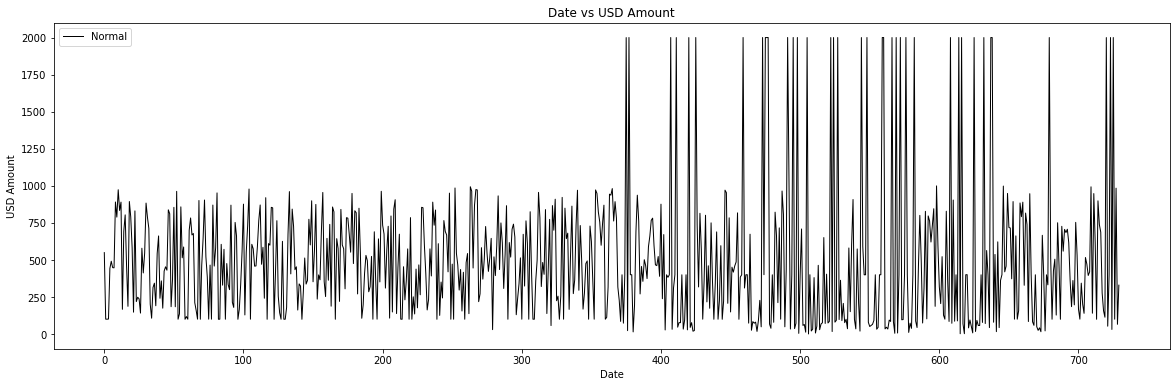

In [38]:
fig, ax = plt.subplots(figsize=(20,6))

a = df1.loc[df1['anomaly_IsolationForest'] == 1][:100]
ac = df_new.loc[df_new['Label']==1]
ax.plot(df1['USD_amount'][:730], color='black', label = 'Normal', linewidth=1.0)
plt.legend()
plt.title("Date vs USD Amount")
plt.xlabel('Date')
plt.ylabel('USD Amount')
plt.show();

#### Anomaly points detected by Isolation Forest

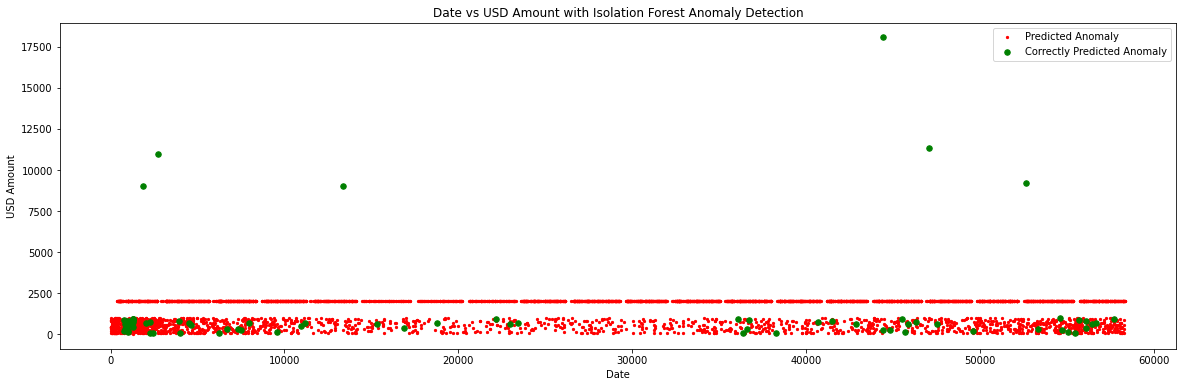

In [39]:
# Plotting Date vs USD Amount graph having the correctly predicted anomalies using Isolation Forest 
fig, ax = plt.subplots(figsize=(20,6))


a = df1.loc[df1['anomaly_IsolationForest'] == 1][:]
a1 = a.loc[a['Label'] == 1]


a2 = df1.loc[df1['Label'] == 1]
ac = df_new.loc[df_new['Label']==1]
ax.scatter(a.index ,a['USD_amount'], color='red', label = 'Predicted Anomaly', s=5)
ax.scatter(a1.index ,a1['USD_amount'], color='green', label = 'Correctly Predicted Anomaly', s=30)


plt.legend()
plt.title("Date vs USD Amount with Isolation Forest Anomaly Detection")
plt.xlabel('Date')
plt.ylabel('USD Amount')
plt.show();

<AxesSubplot:>

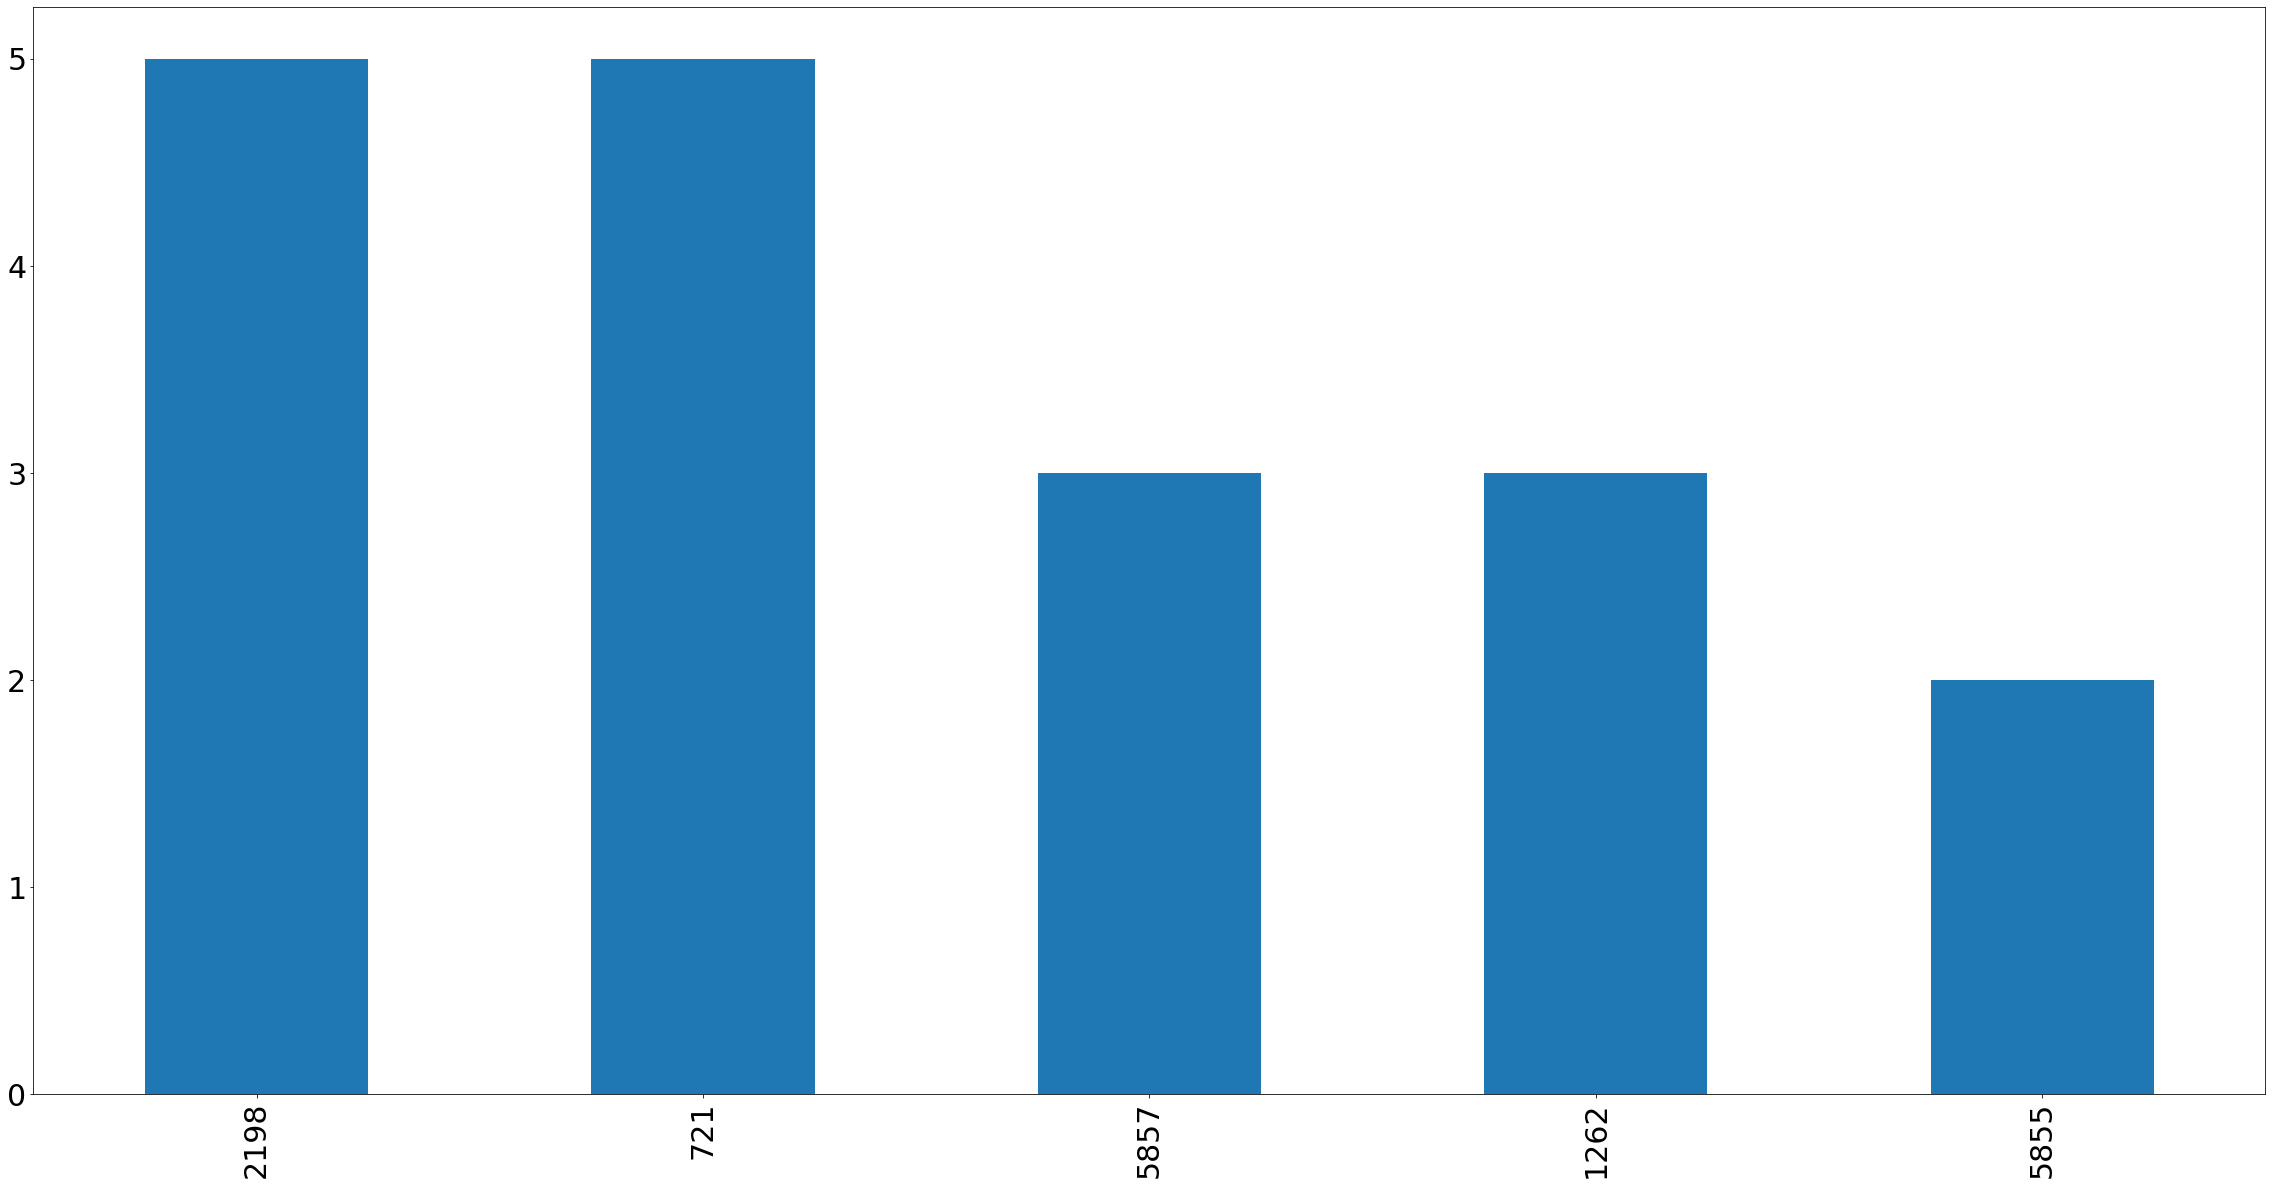

In [40]:
# Most anomalous Sender Id's(Correctly predicted values)
ab = a1['Sender_Id'].value_counts()
abc = a1['Bene_Id'].value_counts()
ab.iloc[:5].plot(y='', kind='bar',figsize=(40,20), fontsize=30)

<AxesSubplot:>

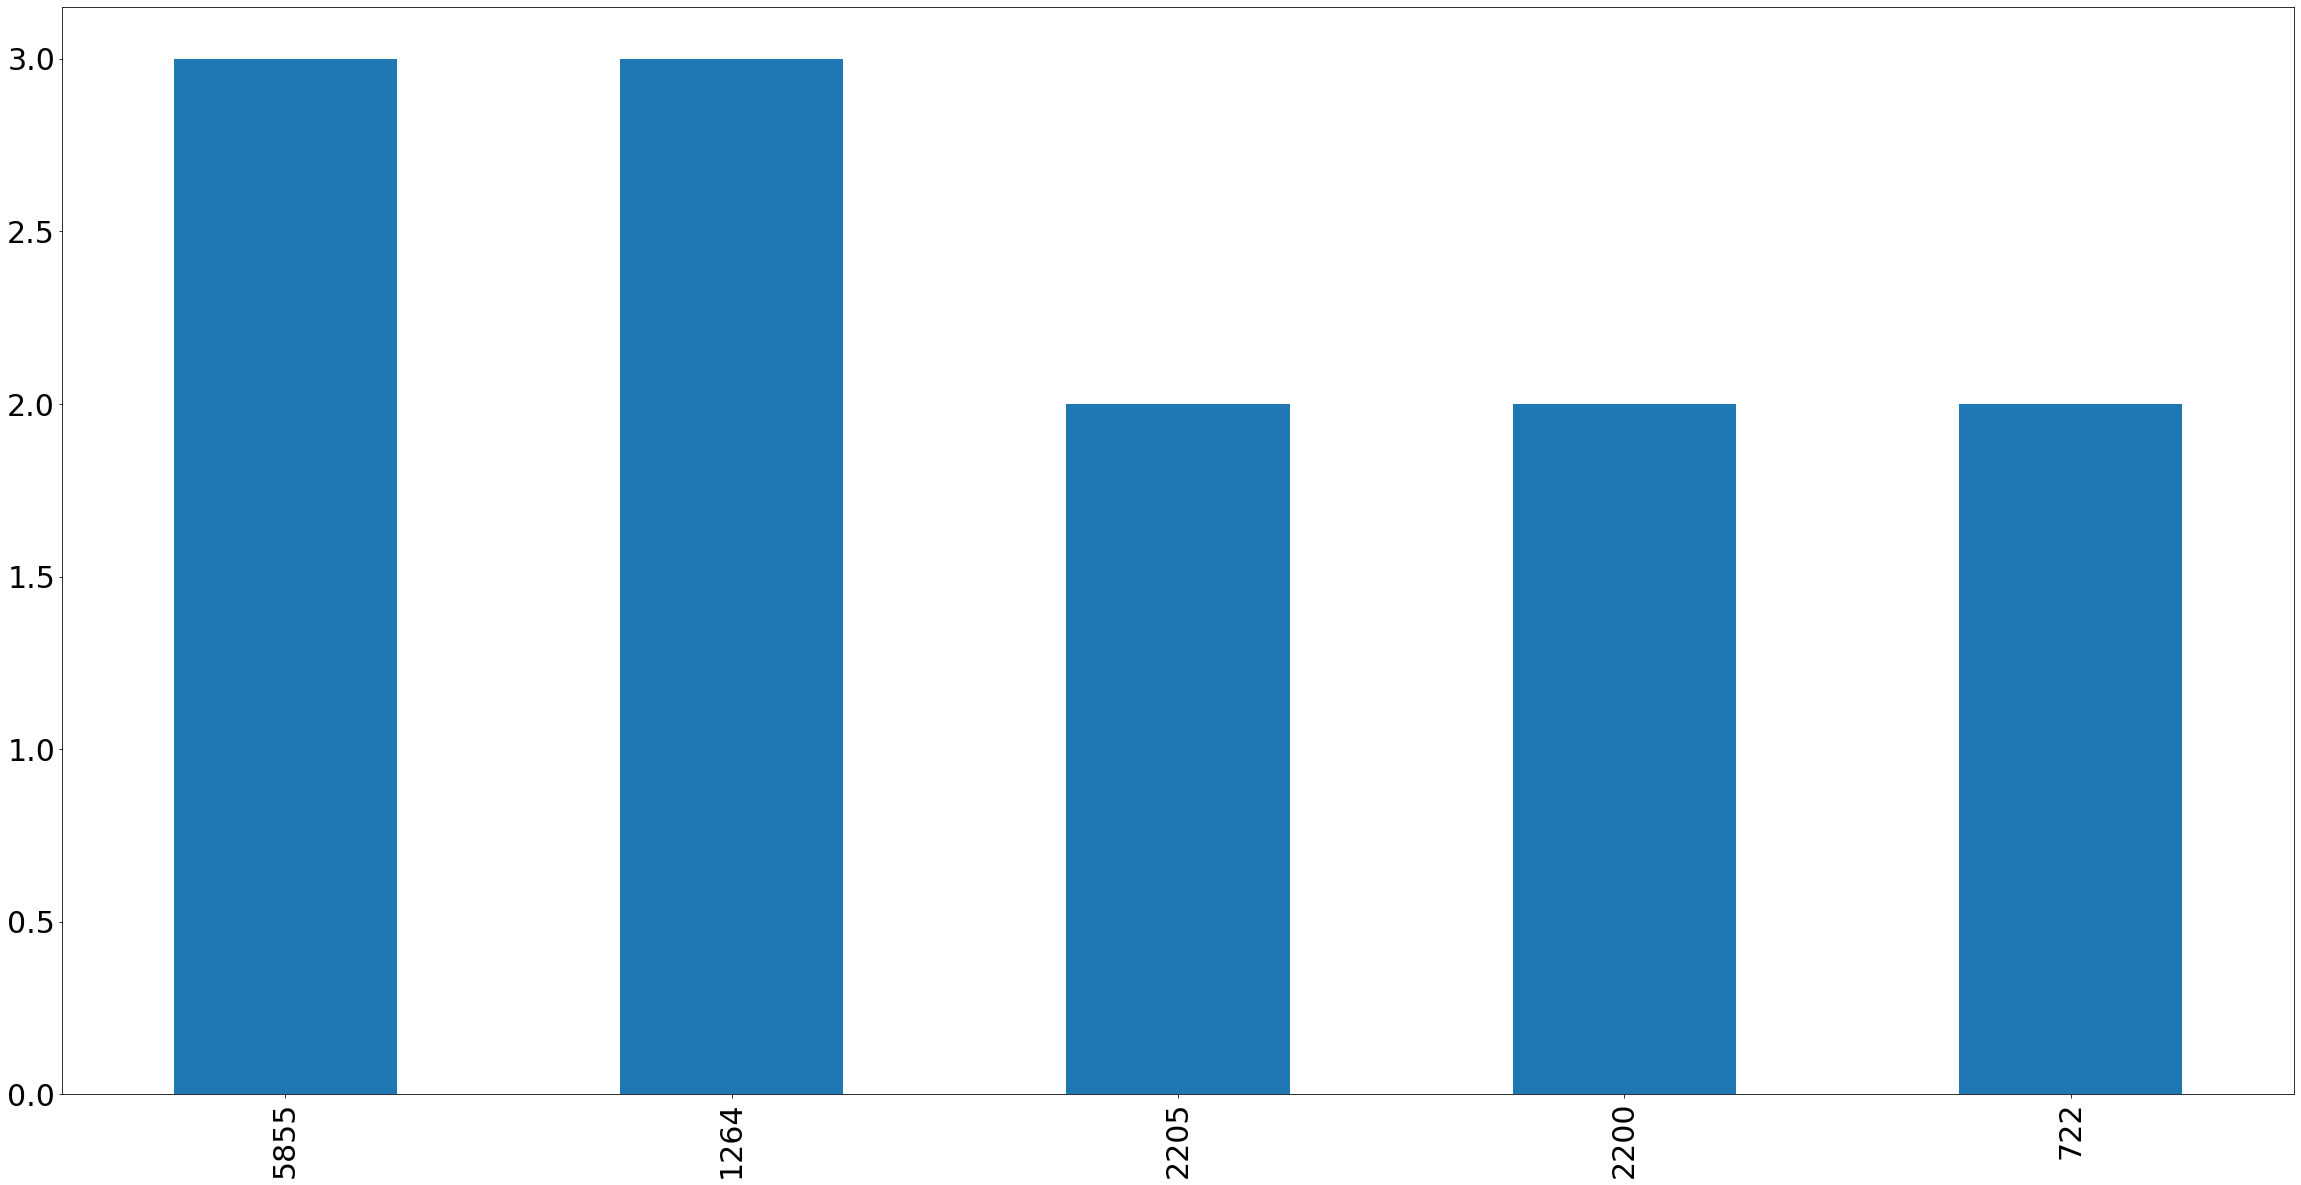

In [41]:
# Most anomalous Bene Id's(Correctly predicted values)
abc.iloc[:5].plot(y='', kind='bar',figsize=(40,20), fontsize=30)

In [42]:
# Relation between the correctly predicted Sender Id's and Bene Id's
aaa = a1.groupby(["Sender_Id", "Bene_Id"]).size().reset_index(name="Time")
aaa = aaa.sort_values(by='Time', ascending=False)
print(aaa[:4])

    Sender_Id  Bene_Id  Time
16       5857     5855     3
7        1262     1264     3
0         721      722     2
1         721      724     2


### Extract feature importances from Isolation Forest

In [43]:
detector = transformer_IF.primitives[0]._clf.detector_
est = transformer_IF.primitives[0]._clf.detector_.estimators_

In [44]:
#100 eastimators with 520 features
feat_importance = np.zeros(520)
feat_importance=[]
for est in detector.estimators_:
    feat_importance.append(est.feature_importances_)
feat_importance = np.array(feat_importance)

In [45]:
print(feat_importance.shape)

(100, 516)


In [46]:
a = []
b = []

for i in feat_importance:
    a = np.argsort(i)
    b.append(a[-1])

c = collections.Counter(b)

In [47]:
#Rank from most to least feature importances: [feature column, number of appearances]
a = []

for i,j in c.items():
    a.append([i,j])
    
a = sorted(a,reverse=True, key=lambda x:x[1])
#print(a)

In [48]:
a1 = []
a2 = []

for i,j in a:
    a1.append(str(i))
    a2.append(j)

### Ranking of features for the columns

#### Combine one-hot encoded columns

In [49]:
dict_2 = defaultdict(int)
for i in a:
    for key, value in dict_1.items():
        if i[0] in value:
            dict_2[key] += i[1]
            break

dict_2["Transaction_Id"] = c[0]
dict_2["USD_amount"] = c[6]
dict_2["Sender_Account"] = c[2]
dict_2["Sender_Sector"] = c[3]
dict_2["Bene_Account"] = c[5]

In [50]:
print(dict_2)

defaultdict(<class 'int'>, {'Sender_Id': 12, 'Bene_Id': 8, 'Sender_Country': 13, 'Bene_Country': 25, 'Transaction_Type': 1, 'Transaction_Id': 10, 'USD_amount': 10, 'Sender_Account': 5, 'Sender_Sector': 8, 'Bene_Account': 7})


In [51]:
a3=[]
a4=[]
for key,value in dict_2.items():
    a3.append(key)
    a4.append(value)

#### Plot the original 12 feature importances

<BarContainer object of 10 artists>

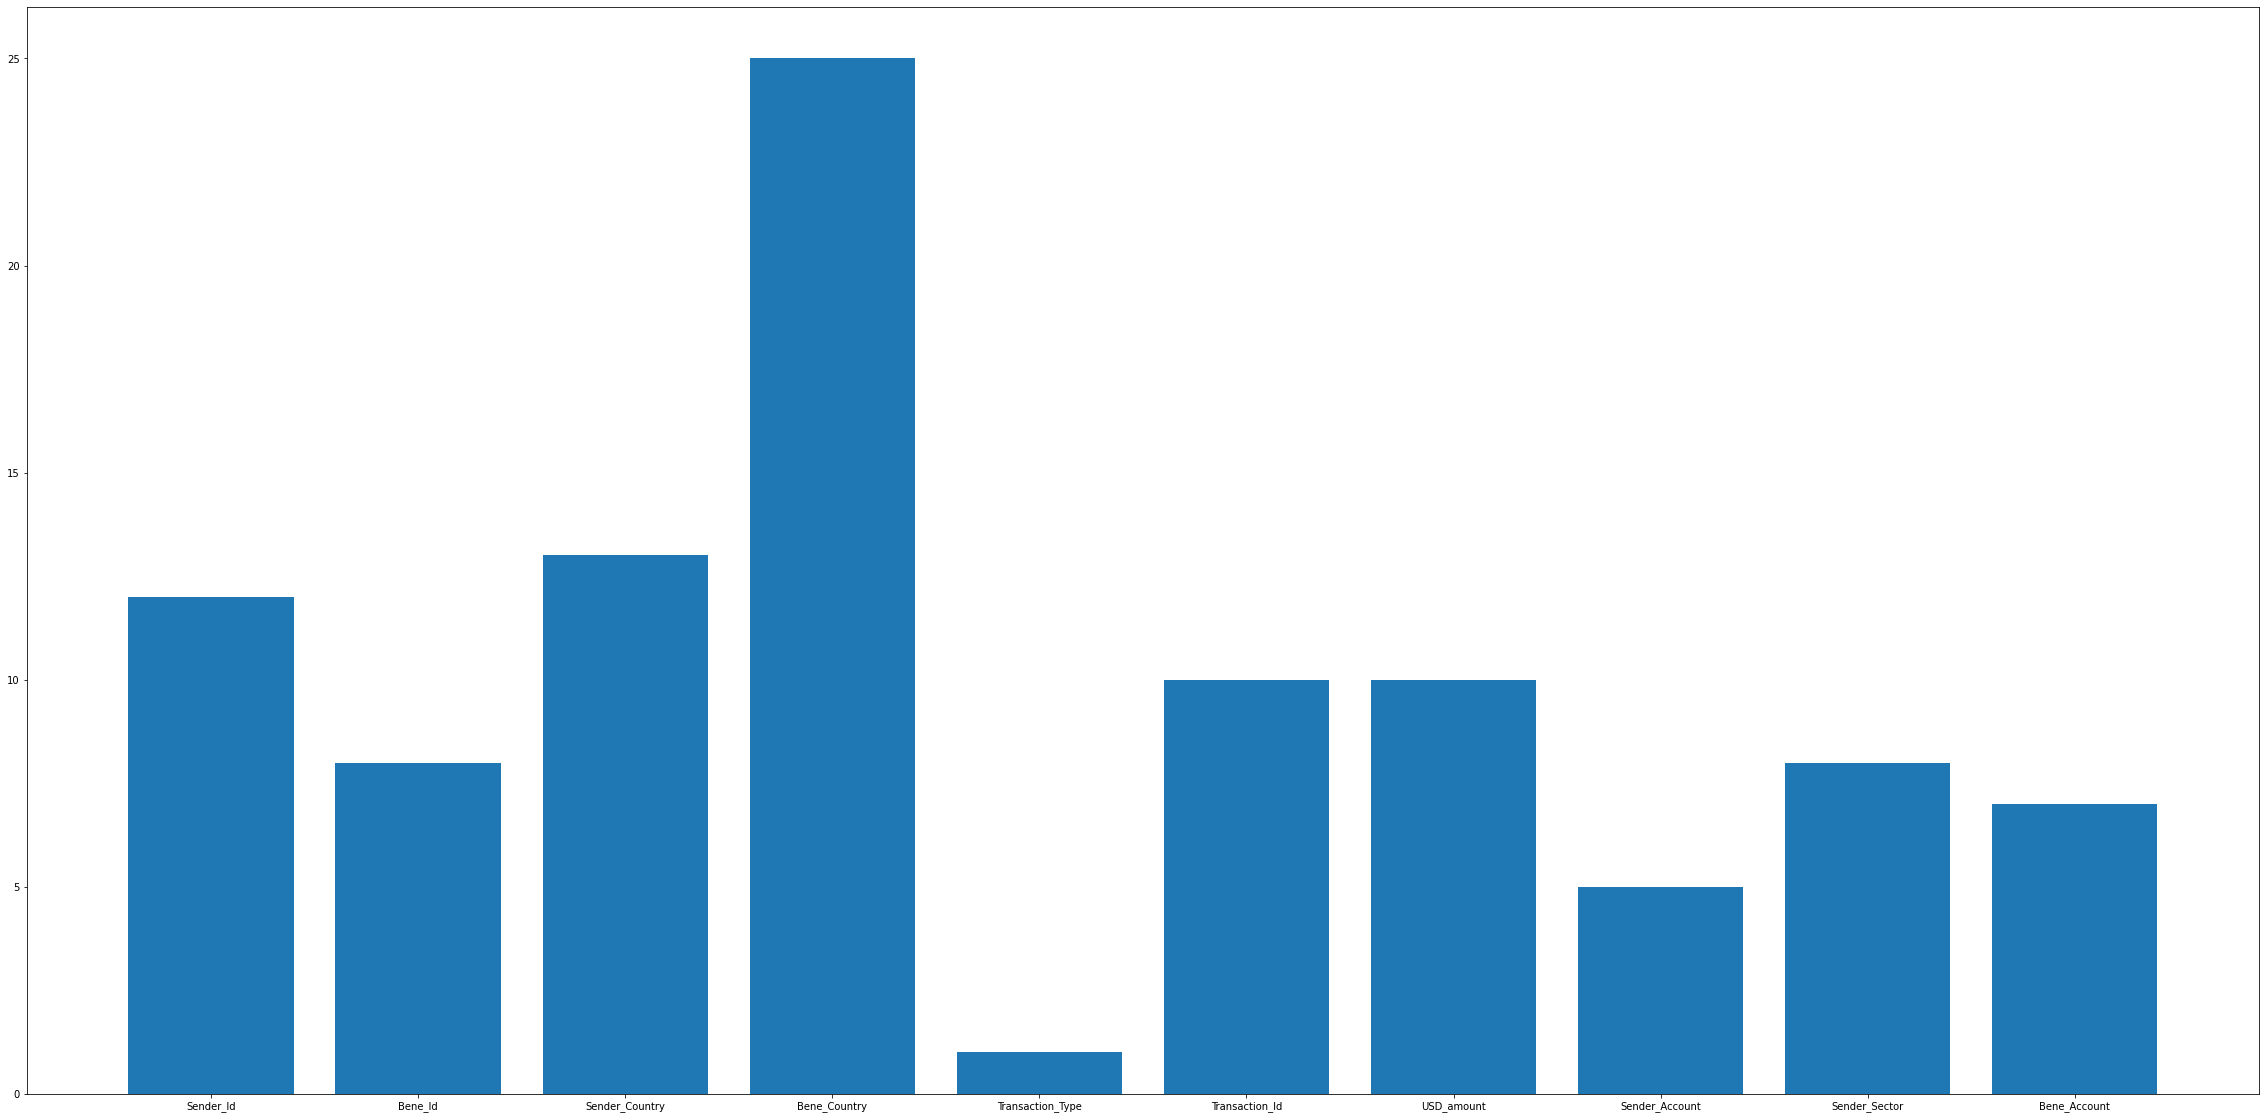

In [52]:
# Plotting the feature importances of the columns to get an idea about the most important feature.
f, ax = plt.subplots(figsize=(40,20))
plt.bar(a3,a4)

### Predicted Anomaly Ratio for Countries in Bene_Country

(183, 2)


<AxesSubplot:>

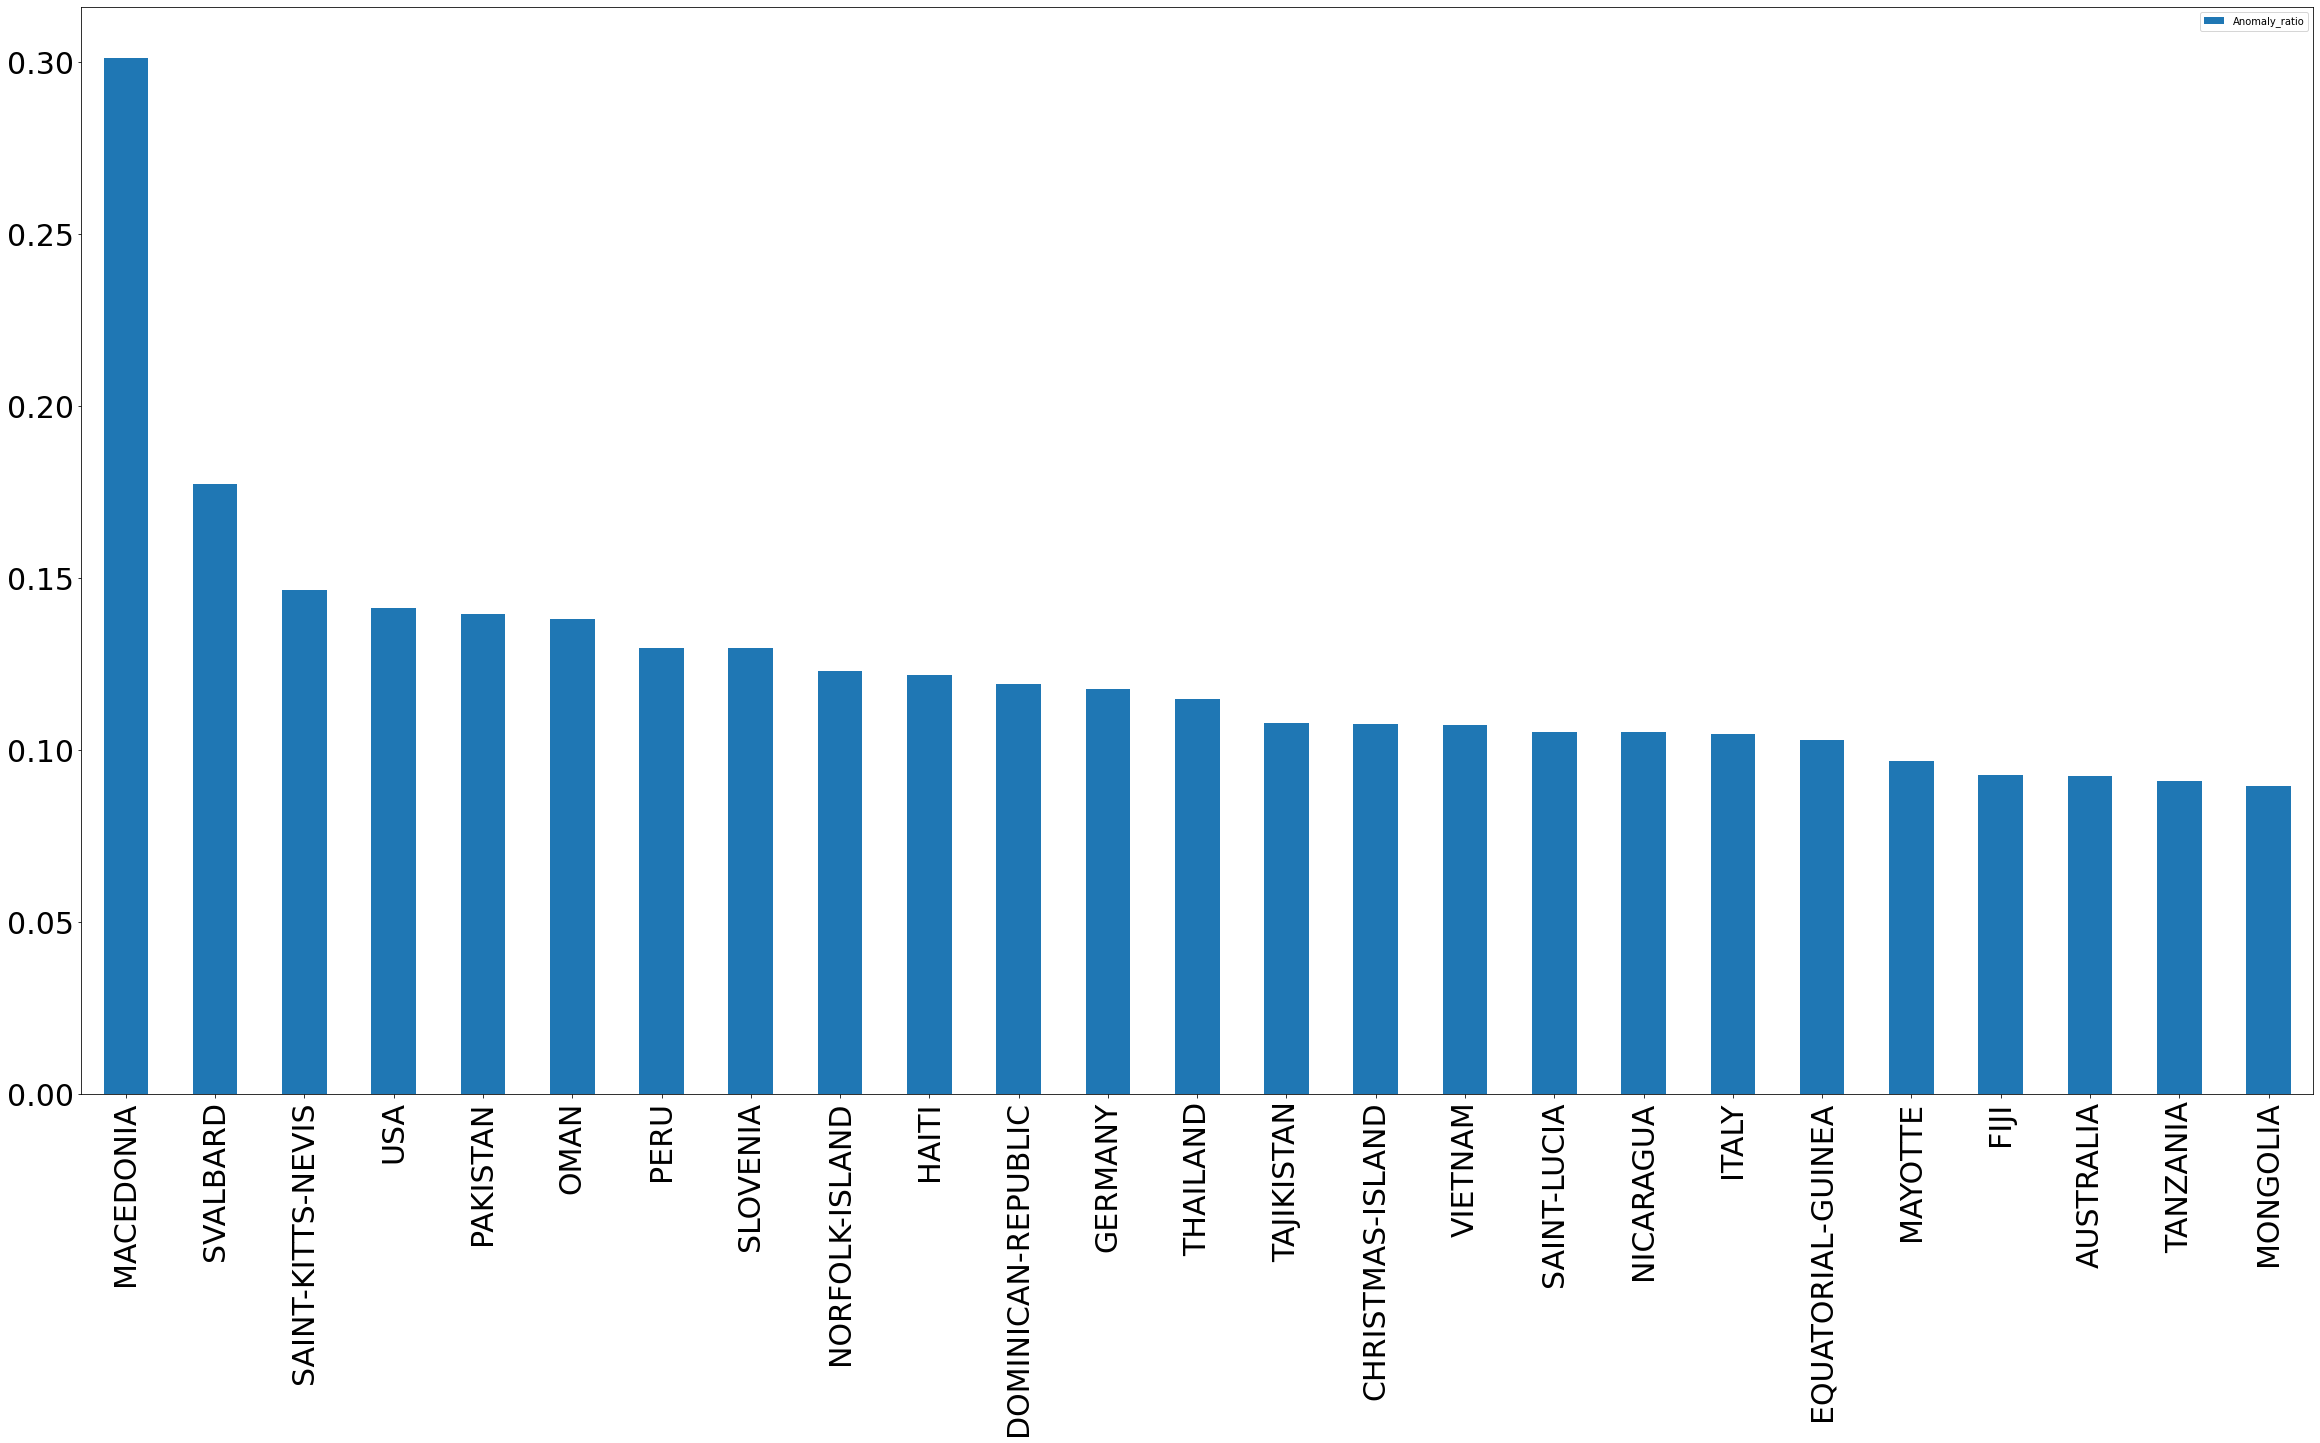

In [53]:
df_new1 = df1.copy()
df_ano1 = pd.DataFrame()
df_new1 = df1.loc[df1['anomaly_IsolationForest'] == 1]

x = df_new1['Bene_Country'].value_counts()
df_ano1 = pd.concat([df_ano1, x], axis = 1)

df_ano1['Anomaly_ratio'] = df_ano1['Bene_Country']
del df_ano1['Bene_Country']

y = df1['Bene_Country'].value_counts()
df_ano1 = pd.concat([df_ano1, y], axis = 1)
df_ano1['Anomaly_ratio'] = df_ano1['Anomaly_ratio']/df_ano1['Bene_Country']
df_ano1 = df_ano1.dropna()
print(df_ano1.shape)
df_ano1 = df_ano1.sort_values(by='Anomaly_ratio', ascending=False)

df_ano1.iloc[:25].plot(y='Anomaly_ratio', kind='bar',figsize=(40,20), fontsize=30)

## Dropping "Bene_Country" column to compare difference

In [54]:
df3.drop(df3.iloc[:, 261:513], inplace = True, axis = 1)

In [55]:
#prepare the data
df4 = df3.copy()
df3 = df3.drop(columns=['Label'])
df3.head()

,Transaction_Id,Sender_Id,Sender_Account,Sender_Sector,Bene_Id,Bene_Account,USD_amount,BILLCOMPANY_S,CLIENT_S,COMPANY_S,...,VIRGIN-ISLANDS-BRITISH_S,VIRGIN-ISLANDS-US_S,WALLIS-FUTUNA-IS_S,YEMEN_S,ZAMBIA_S,ZIMBABWE_S,MAKE-PAYMENT,MOVE-FUNDS,PAY-CHECK,QUICK-PAYMENT
0,6497,6480,6491,27344.0,6498,6499,549.71,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,6500,6480,6490,43006.0,6501,6502,100.96,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,6345,6325,6339,18460.0,6327,6336,100.74,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,6346,6325,6338,23932.0,6333,6344,101.90,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,6168,6151,6162,6692.0,6154,6160,443.14,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [56]:
to_model_columns = df3.columns[0:]
df3 = df3[to_model_columns]
X = np.expand_dims(df3, axis=1)
X = np.squeeze(X)
y_true = np.expand_dims(df_L, axis=1)
y_true = np.squeeze(y_true)

In [57]:
transformer_IF = IsolationForestSKI(contamination=0.09)
transformer_IF.fit(X)

In [58]:
prediction_labels_IF = transformer_IF.predict(X)
prediction_score_IF = transformer_IF.predict_score(X)

In [59]:
y_pred = prediction_labels_IF

print('Accuracy Score: ', accuracy_score(y_true, y_pred))

confusion_matrix(y_true, y_pred)

print(classification_report(y_true, y_pred))

Accuracy Score:  0.8921568627450981
              precision    recall  f1-score   support

           0       0.98      0.91      0.94     57156
           1       0.01      0.06      0.02      1188

    accuracy                           0.89     58344
   macro avg       0.50      0.49      0.48     58344
weighted avg       0.96      0.89      0.92     58344



### Visualisation after dropping column

In [60]:
df_bene.to_csv('test12.csv', index=False)
df_bene = pd.read_csv('test12.csv')

In [61]:
# create a new column for storing the results of Isolation Forest method
df4['anomaly_IsolationForest'] = pd.Series(prediction_labels_IF.flatten())
df4['anomaly_IsolationForest'] = df4['anomaly_IsolationForest'].apply(lambda x: x == 1)
df4['anomaly_IsolationForest'] = df4['anomaly_IsolationForest'].astype(int)
df4['anomaly_IsolationForest1'] = df1['anomaly_IsolationForest']
df4['anomaly_IsolationForest'].value_counts()
df4["Bene_Country"] = df_bene["Bene_Country"]

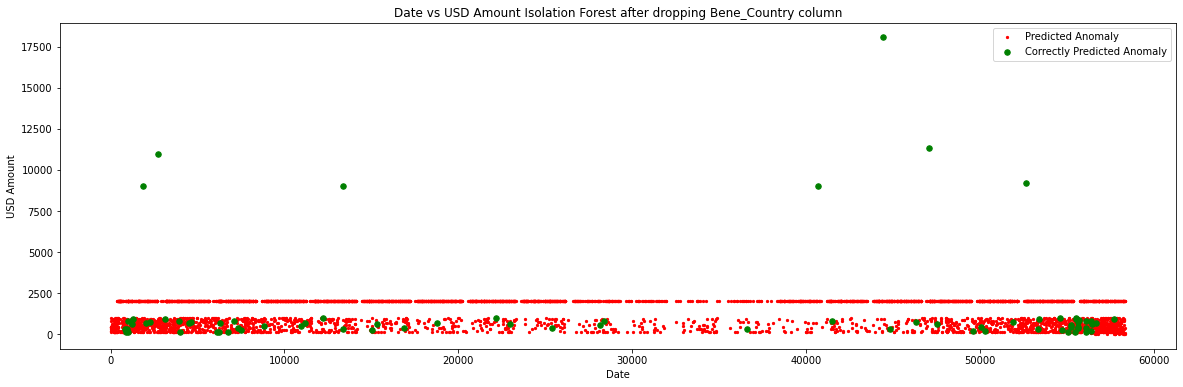

In [62]:
# Plotting (Date vs USD Amount) for correctly predicted anomalies using Isolation Forest dropped the Bene_Country column
fig, ax = plt.subplots(figsize=(20,6))


a = df4.loc[df4['anomaly_IsolationForest'] == 1]
a1 = a.loc[a['Label'] == 1]


a2 = df4.loc[df4['Label'] == 1]
ac = df_new.loc[df_new['Label']==1]
ax.scatter(a.index ,a['USD_amount'], color='red', label = 'Predicted Anomaly', s=5)
ax.scatter(a1.index ,a1['USD_amount'], color='green', label = 'Correctly Predicted Anomaly', s=30)


plt.legend()
plt.title("Date vs USD Amount Isolation Forest after dropping Bene_Country column")
plt.xlabel('Date')
plt.ylabel('USD Amount')
plt.show();

(32, 268)


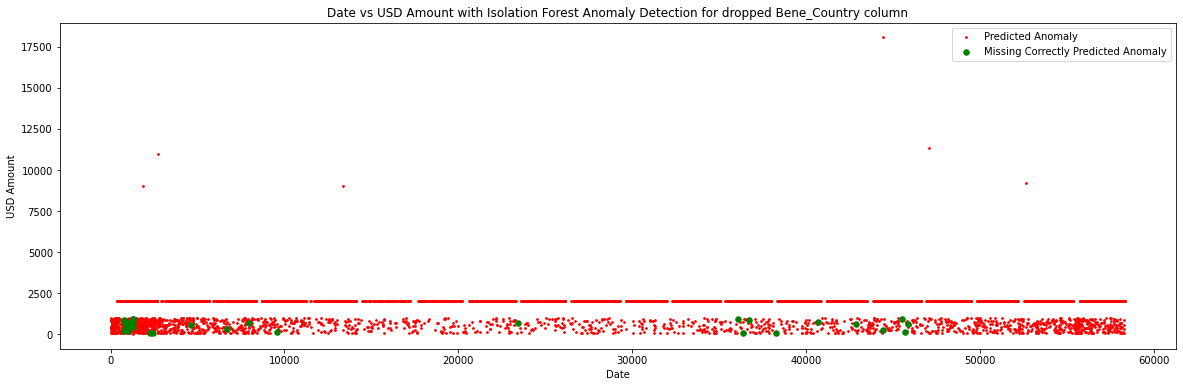

In [63]:
# Plotting the anomalous values that were not identified by dropping Bene_Country
fig, ax = plt.subplots(figsize=(20,6))


a = df4.loc[df4['anomaly_IsolationForest1'] == 1][:]
a4 = a.loc[a['anomaly_IsolationForest'] == 0]
a1 = a4.loc[a4['Label'] == 1]


a2 = df4.loc[df4['Label'] == 1]
ac = df_new.loc[df_new['Label']==1]
ax.scatter(a.index ,a['USD_amount'], color='red', label = 'Predicted Anomaly', s=3)
ax.scatter(a1.index ,a1['USD_amount'], color='green', label = 'Missing Correctly Predicted Anomaly', s=30)
print(a1.shape)

plt.legend()
plt.title("Date vs USD Amount with Isolation Forest Anomaly Detection for dropped Bene_Country column")
plt.xlabel('Date')
plt.ylabel('USD Amount')
plt.show();

### Dropping "Sender_Account" column to compare differences

In [64]:
#prepare the data
data = pd.read_csv('encoded.csv')
data = data.drop(columns=['Label'])
data = data.drop(columns=['Sender_Account'])

In [65]:
to_model_columns = data.columns[0:]
data = data[to_model_columns]
X = np.expand_dims(data, axis=1)
X = np.squeeze(X)
y_true = np.expand_dims(df_L, axis=1)
y_true = np.squeeze(y_true)

In [66]:
transformer_IF = IsolationForestSKI(contamination=0.09)
transformer_IF.fit(X)

In [67]:
prediction_labels_IF = transformer_IF.predict(X)
prediction_score_IF = transformer_IF.predict_score(X)

In [68]:
y_pred = prediction_labels_IF

print('Accuracy Score: ', accuracy_score(y_true, y_pred))

confusion_matrix(y_true, y_pred)

print(classification_report(y_true, y_pred))

Accuracy Score:  0.8915569724393254
              precision    recall  f1-score   support

           0       0.98      0.91      0.94     57156
           1       0.01      0.05      0.02      1188

    accuracy                           0.89     58344
   macro avg       0.49      0.48      0.48     58344
weighted avg       0.96      0.89      0.92     58344



### Visualisation after dropping column

In [69]:
# create a new column for storing the results of Isolation Forest method
df2['anomaly_IsolationForest'] = pd.Series(prediction_labels_IF.flatten())
df2['anomaly_IsolationForest'] = df2['anomaly_IsolationForest'].apply(lambda x: x == 1)
df2['anomaly_IsolationForest'] = df2['anomaly_IsolationForest'].astype(int)
df2['anomaly_IsolationForest1'] = df1['anomaly_IsolationForest']
df2['anomaly_IsolationForest'].value_counts()

0    53093
1     5251
Name: anomaly_IsolationForest, dtype: int64

(33, 519)


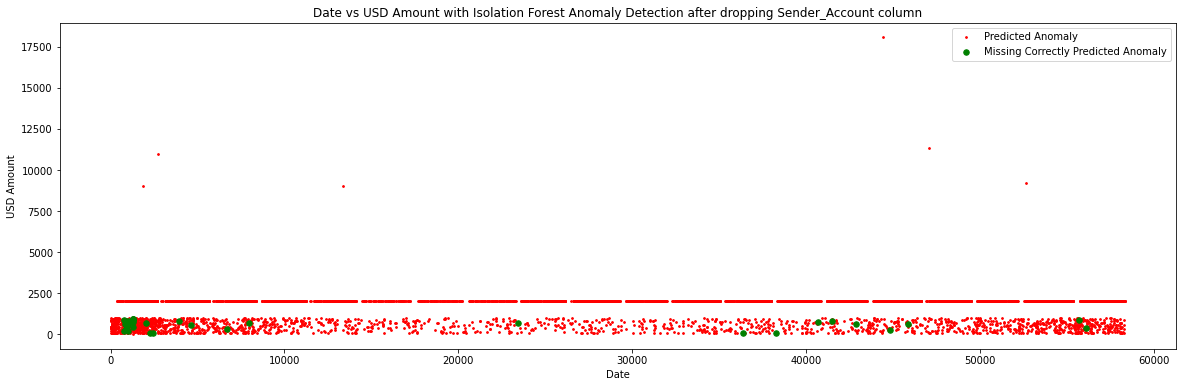

In [71]:
# Plotting the anomalous values that were not identified by dropping Sender_Account
fig, ax = plt.subplots(figsize=(20,6))


a = df2.loc[df2['anomaly_IsolationForest1'] == 1][:]
a4 = a.loc[a['anomaly_IsolationForest'] == 0]
a1 = a4.loc[a4['Label'] == 1]


#a2 = df4.loc[df4['Label'] == 1]
ac = df_new.loc[df_new['Label']==1]
ax.scatter(a.index ,a['USD_amount'], color='red', label = 'Predicted Anomaly', s=3)
ax.scatter(a1.index ,a1['USD_amount'], color='green', label = 'Missing Correctly Predicted Anomaly', s=30)
print(a1.shape)

plt.legend()
plt.title("Date vs USD Amount with Isolation Forest Anomaly Detection after dropping Sender_Account column")
plt.xlabel('Date')
plt.ylabel('USD Amount')
plt.show();